In [19]:
from roboflow import Roboflow

rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("searchandrescue").project("safepointdiscovery")
dataset = project.version(2).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...
Generating version still in progress. Progress: 98.89%



Extracting Dataset Version Zip to SafePointDiscovery-2 in png-mask-semantic:: 100%|██████████| 2788/2788 [00:00<00:00, 3432.42it/s]


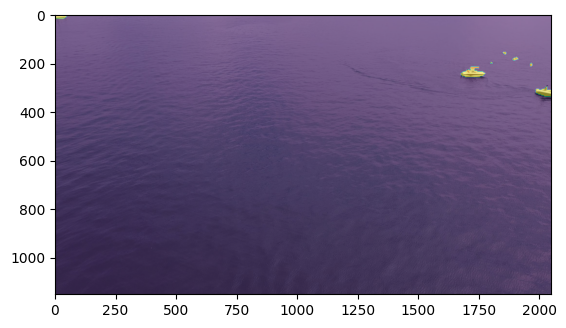

In [20]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

SOURCE_MASK_PATH = "/home/emilia/WaterSegNet/SafePointDiscovery-2/train/713_jpg.rf.6852d6a4b1d9cb392555b3e51a2aa5e8_mask.png"
SOURCE_IMAGE_PATH = "/home/emilia/WaterSegNet/SafePointDiscovery-2/train/713_jpg.rf.6852d6a4b1d9cb392555b3e51a2aa5e8.jpg"
raw_mask = Image.open(SOURCE_MASK_PATH)
raw_image = Image.open(SOURCE_IMAGE_PATH)
image_array = np.array(raw_mask)
binary_mask = np.where(image_array == 1, 255, 0).astype(np.uint8)

mask_img = Image.fromarray(binary_mask)

plt.imshow(raw_image)
plt.imshow(mask_img, alpha=0.5)

In [22]:
import os
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np


def refine_mask(mask):
    # Define kernel for morphological operations
    kernel = np.ones((20, 20), np.uint8)

    # Apply morphological operations
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Choose one based on your requirement
    refined_mask = mask_closed
    inverted_mask = cv2.bitwise_not(refined_mask)

    # Return the mask
    return inverted_mask


def process_mask(image_path, save_path):
    image = Image.open(image_path)

    np_image = np.array(image)
    binary_mask = np.where(np_image == 1, 255, 0).astype(np.uint8)
    refined_mask = refine_mask(binary_mask)
    pil_image = Image.fromarray(refined_mask)

    pil_image.save(save_path, format="PNG")


def separate_and_rename_files(source_folder, image_save_folder, mask_save_folder):
    counter = 0

    for filename in tqdm(sorted(os.listdir(source_folder))):
        file_path = os.path.join(source_folder, filename)

        if filename.endswith(".jpg"):  # Process and save image
            new_filename = f"{counter:04d}.png"
            save_path = os.path.join(image_save_folder, new_filename)
            Image.open(file_path).save(save_path)

        elif filename.endswith("_mask.png"):  # Save label
            new_filename = f"{counter:04d}.png"
            save_path = os.path.join(mask_save_folder, new_filename)
            process_mask(file_path, save_path)
            counter += 1


# Base directory for dataset
BASE_DATA_FOLDER = "/home/emilia/WaterSegNet"
PROJECT = "SafePointDiscovery-2"
# Folders for original dataset
TEST_DATA_ORIG = f"{BASE_DATA_FOLDER}/{PROJECT}/test"
TRAIN_DATA_ORIG = f"{BASE_DATA_FOLDER}/{PROJECT}/train"
VALID_DATA_ORIG = f"{BASE_DATA_FOLDER}/{PROJECT}/valid"

# Folders for custom dataset
CUSTOM_DATASET_FOLDER = f"{BASE_DATA_FOLDER}/waterSeg_dataset"

TEST_MASK_FOLDER = f"{CUSTOM_DATASET_FOLDER}/test/labels"
TEST_IMAGE_FOLDER = f"{CUSTOM_DATASET_FOLDER}/test/images"

TRAIN_MASK_FOLDER = f"{CUSTOM_DATASET_FOLDER}/train/labels"
TRAIN_IMAGE_FOLDER = f"{CUSTOM_DATASET_FOLDER}/train/images"

VALID_MASK_FOLDER = f"{CUSTOM_DATASET_FOLDER}/valid/labels"
VALID_IMAGE_FOLDER = f"{CUSTOM_DATASET_FOLDER}/valid/images"


separate_and_rename_files(VALID_DATA_ORIG, VALID_IMAGE_FOLDER, VALID_MASK_FOLDER)
separate_and_rename_files(TRAIN_DATA_ORIG, TRAIN_IMAGE_FOLDER, TRAIN_MASK_FOLDER)
separate_and_rename_files(TEST_DATA_ORIG, TEST_IMAGE_FOLDER, TEST_MASK_FOLDER)

100%|██████████| 111/111 [00:15<00:00,  7.03it/s]


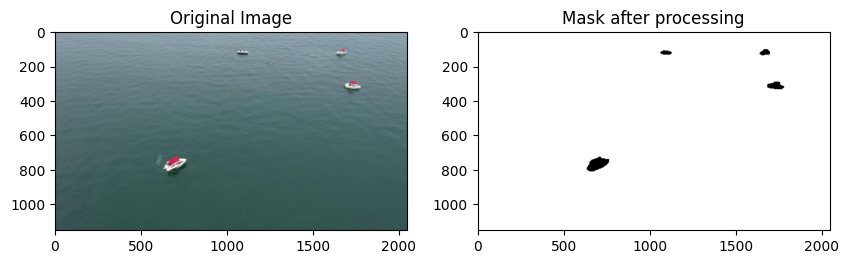

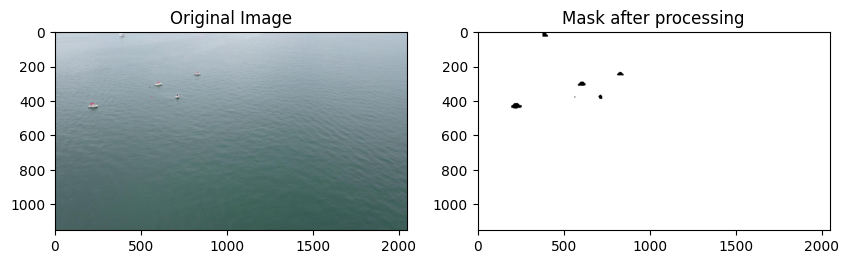

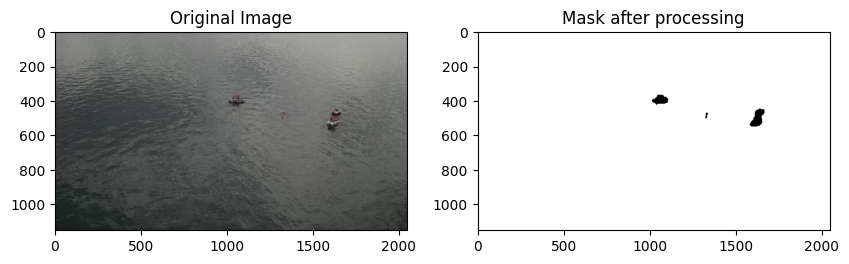

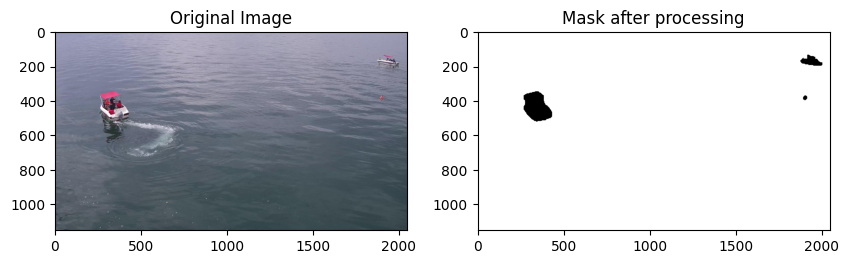

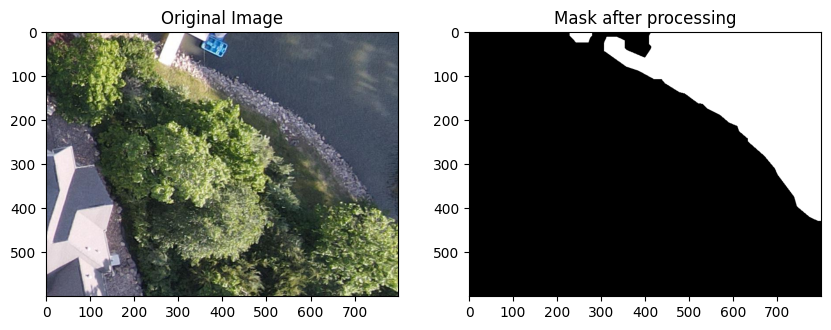

In [24]:
# Refine Masks

import cv2
import numpy as np

from matplotlib import pyplot as plt


for i in range(0, 5):
    image = Image.open(f"{TEST_IMAGE_FOLDER}/{i:04d}.png")
    mask = Image.open
    refined_mask = Image.open(f"{TEST_MASK_FOLDER}/{i:04d}.png")

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")

    ax[1].imshow(refined_mask, cmap="gray")
    ax[1].set_title("Mask after processing")
    plt.show()

### Prepare satelite data


In [13]:
import os
import shutil
from tqdm import tqdm

# Base directory for dataset
BASE_DATA_FOLDER = "/home/emilia/WaterSegNet/"
PROJECT = "segmentation_full_dataset"
# Folders for original dataset
TEST_DATA_ORIG = f"{BASE_DATA_FOLDER}/{PROJECT}/test"
TRAIN_VAL_DATA_ORIG = f"{BASE_DATA_FOLDER}/{PROJECT}"

# Folders for custom dataset
TARGET_DATASET_FOLDER = f"{BASE_DATA_FOLDER}/datasets/satelite_dataset"

TEST_MASK_FOLDER = f"{TARGET_DATASET_FOLDER}/test/labels"
TEST_IMAGE_FOLDER = f"{TARGET_DATASET_FOLDER}/test/images"

TRAIN_MASK_FOLDER = f"{TARGET_DATASET_FOLDER}/train/labels"
TRAIN_IMAGE_FOLDER = f"{TARGET_DATASET_FOLDER}/train/images"

VALID_MASK_FOLDER = f"{TARGET_DATASET_FOLDER}/valid/labels"
VALID_IMAGE_FOLDER = f"{TARGET_DATASET_FOLDER}/valid/images"


split_ratio = 0.8
images = sorted(
    [
        f
        for f in os.listdir(os.path.join(TRAIN_VAL_DATA_ORIG, "images"))
        if f.endswith(".png")
    ]
)
labels = sorted(
    [
        f
        for f in os.listdir(os.path.join(TRAIN_VAL_DATA_ORIG, "labels"))
        if f.endswith(".png")
    ]
)

assert len(images) == len(labels) and all(
    img.split("_")[0] == lbl.split("_")[0] for img, lbl in zip(images, labels)
)

num_train = int(len(images) * split_ratio)
indices = np.random.permutation(len(images))
train_indices = indices[:num_train]
valid_indices = indices[num_train:]


def copy_and_rename_files(file_indices, split_type):
    for i, idx in enumerate(file_indices, start=1):
        img_src = os.path.join(TRAIN_VAL_DATA_ORIG, "images", images[idx])
        lbl_src = os.path.join(TRAIN_VAL_DATA_ORIG, "labels", labels[idx])

        img_dst = os.path.join(TARGET_DATASET_FOLDER, split_type, "images", f"{i}.png")
        lbl_dst = os.path.join(TARGET_DATASET_FOLDER, split_type, "labels", f"{i}.png")

        shutil.copyfile(img_src, img_dst)
        shutil.copyfile(lbl_src, lbl_dst)


def rename_files_in_dir(src_dir, split_type):
    src_dir_img = os.path.join(src_dir, "images")
    files = sorted([f for f in os.listdir(src_dir_img) if f.endswith(".png")])
    for i, filename in enumerate(files, start=1):
        img_src = os.path.join(src_dir, "images", filename)
        lbl_src = os.path.join(src_dir, "labels", filename)

        img_dst = os.path.join(TARGET_DATASET_FOLDER, split_type, "images", f"{i}.png")
        lbl_dst = os.path.join(TARGET_DATASET_FOLDER, split_type, "labels", f"{i}.png")

        shutil.copyfile(img_src, img_dst)
        shutil.copyfile(lbl_src, lbl_dst)


copy_and_rename_files(train_indices, "train")
copy_and_rename_files(valid_indices, "valid")
rename_files_in_dir(TEST_DATA_ORIG, "test")

### Merge both datasets into one large dataset


In [ ]:
import os
import shutil

# Define source dataset directories
DATASET1 = "/home/emilia/WaterSegNet/datasets/satelite_dataset"
DATASET2 = "/home/emilia/WaterSegNet/datasets/uav_dataset"
SRC_TEST_DIR1 = os.path.join(DATASET1, "test")
SRC_TRAIN_DIR1 = os.path.join(DATASET1, "train")
SRC_VALID_DIR1 = os.path.join(DATASET1, "valid")
SRC_TEST_DIR2 = os.path.join(DATASET2, "test")
SRC_TRAIN_DIR2 = os.path.join(DATASET2, "train")
SRC_VALID_DIR2 = os.path.join(DATASET2, "valid")


# Define target dataset directories
TARGET_DATASET = "/home/emilia/WaterSegNet/datasets/complete_dataset"
TARGET_TEST_DIR = os.path.join(TARGET_DATASET, "test")
TARGET_TRAIN_DIR = os.path.join(TARGET_DATASET, "train")
TARGET_VALID_DIR = os.path.join(TARGET_DATASET, "valid")


# Function to copy and rename files from a source to a target directory
def merge_and_rename(source_dir, target_dir):
    existing_files = len(os.listdir(target_dir))
    for i, filename in tqdm(
        enumerate(sorted(os.listdir(source_dir)), start=existing_files + 1)
    ):
        src = os.path.join(source_dir, filename)
        dst = os.path.join(target_dir, f"{i}.png")
        shutil.copy(src, dst)


# Merge and rename files in the 'images' subfolders
merge_and_rename(
    os.path.join(SRC_VALID_DIR1, "images"), os.path.join(TARGET_VALID_DIR, "images")
)
merge_and_rename(
    os.path.join(SRC_VALID_DIR2, "images"), os.path.join(TARGET_VALID_DIR, "images")
)

# Merge and rename files in the 'labels' subfolders
merge_and_rename(
    os.path.join(SRC_VALID_DIR1, "labels"), os.path.join(TARGET_VALID_DIR, "labels")
)
merge_and_rename(
    os.path.join(SRC_VALID_DIR2, "labels"), os.path.join(TARGET_VALID_DIR, "labels")
)

print("Datasets merged and files renamed successfully.")